In [1]:
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from replay_analysis import ExperienceRelay
from replay_analysis import filter_frames
from replay_analysis import get_debug_values

from rover_model.perception import PerspectiveRender
from rover_model.perception import StripwiseInterpolationOptimized
from rover_model.perception import PitchCalibratedPerspectiveInference
from rover_model.perception import ZYXRotatedPerspectiveInference
from rover_model.perception import ZXYRotatedPerspectiveInference
from rover_model.perception import highlight_position
from rover_model.perception import GradientAnalysis

from rover_agent.frame_geometry import convert_camera_coords
from rover_agent.frame_geometry import color_thresh
from rover_agent.frame_geometry import circle_distance
from rover_agent.frame_geometry import inverse_rotation_matrix

from rover_resource import VIEW_POINT_POSITION
from rover_resource import PIXEL_SCALING
from rover_resource import CAMERA_POSITION
from rover_resource import FRAME_SHAPE
from rover_resource import DEFAULT_THRESHOLD
from rover_resource import GROUND_TRUTH_MAP

gradient_analyzer = GradientAnalysis(GROUND_TRUTH_MAP)
replay = ExperienceRelay('./experiments/optimize_mapping_rotated/', from_csv=True)
replay.replay()
frames = replay.frames
map_gradients = get_debug_values(frames, 'map_gradients')

SINGULAR_PIXEL = int(VIEW_POINT_POSITION[0] * PIXEL_SCALING)
interpo = StripwiseInterpolationOptimized(
    SINGULAR_PIXEL, PIXEL_SCALING, 
    lambda x: np.array(color_thresh(x, (160, 160, 160), 'float32').nonzero()))
perspect = PitchCalibratedPerspectiveInference(CAMERA_POSITION, VIEW_POINT_POSITION)
rot_perspect = ZYXRotatedPerspectiveInference(CAMERA_POSITION, VIEW_POINT_POSITION)
render = PerspectiveRender(scale=1, resolution=60)

In [5]:
zyx_frames = filter_frames(frames, key='type', value='zyx')
pitch_frames = filter_frames(frames, key='type', value='pitch')
print('frame size zyx = ', len(zyx_frames), ' pitch = ', len(pitch_frames))
pitch_cases = [x for x in pitch_frames if x.fidelity < 80]
zyx_cases = [x for x in zyx_frames if x.fidelity < 80]
print('pitch and zyx cases num:', len(pitch_cases), len(zyx_cases))

frame size zyx =  2831  pitch =  2890
pitch and zyx cases num: 2123 2129


In [6]:
import numpy as np
from collections import namedtuple
import matplotlib.image as mpimg

GradientMetric = namedtuple('GradientMetric', ('pos', 'neg', 'render', 'ratio'))

class GradientAnalysis(object):

  def __init__(self, ground_truth):
    truth = mpimg.imread(ground_truth)
    self._truth = np.zeros(shape=truth.shape + (3,), dtype=np.uint8)
    self._truth[:, :, 1] = truth * 255

  def analysis(self, gradient, render=False):
    num_pos = (self._truth[gradient[1], gradient[0], 1] > 0).sum()
    num_neg = gradient.shape[1] - num_pos
    ratio = float(num_pos) / gradient.shape[1]
    if render:
        ret = self._truth.copy()
        ret[gradient[1], gradient[0], :] = 255
        render = np.flipud(ret)
    else:
        render = None
    return GradientMetric(pos=num_pos, neg=num_neg, render=render, ratio=ratio)

In [10]:
pitch_analysis = [(gradient_analyzer.analysis(x.debug['map_gradients']), x) for x in pitch_frames]
zyx_analysis = [(gradient_analyzer.analysis(x.debug['map_gradients']), x) for x in zyx_frames]
pitch_cases = [x for m, x in pitch_analysis if m.ratio < 0.6]
zyx_cases = [x for m, x in zyx_analysis if m.ratio < 0.6]
print('number of cases:', len(pitch_cases), len(zyx_cases))

number of cases: 134 169


frame type info zyx
roll and pitch error: 1.13171386719 1.83657205105
yaw = 299.586 pitch =  1.83657 roll =  358.868
frame position: 111.39 53.0997
SINGULAR =  80
max x info: 0.03996875 5.5454370257
map gradient: ratio = 0.5263157894736842 pos = 10 neg = 9


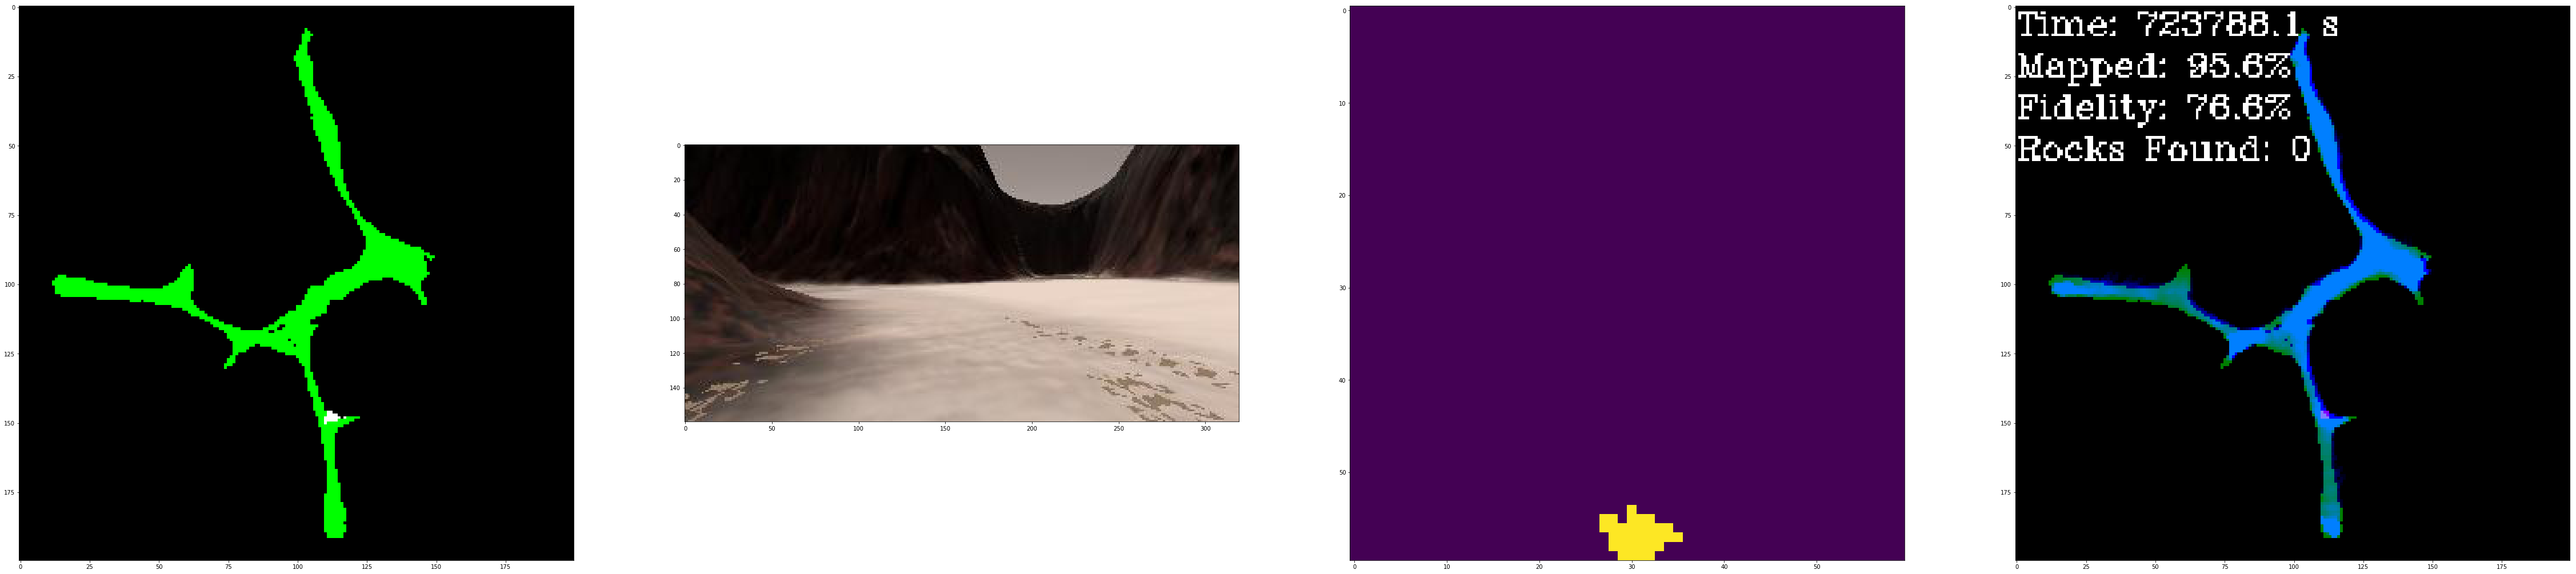

In [24]:
frame = zyx_cases[110]
#frame = frames[2100]
print('frame type info', frame.debug['type'])
#frame = frames[252]
#frame = high_fid_frames[0]
print('roll and pitch error:', circle_distance(frame.metric['Roll'], 0), 
      circle_distance(frame.metric['Pitch'], 0))
print ('yaw =', frame.metric['Yaw'], 'pitch = ', frame.metric['Pitch'], 'roll = ', frame.metric['Roll'])
print('frame position:', frame.metric['X_Position'], frame.metric['Y_Position'])
fig = plt.figure(figsize=(80,160)) # Create a figure for plotting
mp = highlight_position(frame.map, frame.metric['X_Position'], frame.metric['Y_Position'])

horizon_length = 320.0 / PIXEL_SCALING

pitch = (frame.metric['Pitch'] / 180) * np.pi
roll = -(frame.metric['Roll'] / 180) * np.pi
SINGULAR_ORI = int(perspect.get_singular(pitch) * PIXEL_SCALING)
SINGULAR = int(rot_perspect.get_singular(
    roll=roll, pitch=pitch, horizon_length=horizon_length) * PIXEL_SCALING)
print('SINGULAR = ', SINGULAR)
coords = convert_camera_coords(frame.frame)
particles = interpo.extract_particles(coords, singular=SINGULAR)

particles_ori = interpo.extract_particles(coords, singular=SINGULAR_ORI)
s_coords_ori = perspect.particle_transform(pitch, particles_ori)
s_coords = rot_perspect.particle_transform(
    pitch=pitch, roll=roll, particles=particles)

print('max x info:', particles[0, :].max(), s_coords[:, 0].max())
persp = render.render(s_coords)
persp_ori = render.render(s_coords_ori)

analysis = gradient_analyzer.analysis(
    frame.debug['map_gradients'], render=True)
print('map gradient: ratio =', analysis.ratio, 
      'pos =',analysis.pos, 'neg =', analysis.neg)
plt.subplot(141)
plt.imshow(analysis.render)
plt.subplot(142)
plt.imshow(frame.frame)
plt.subplot(143)
plt.imshow(persp)
plt.subplot(144)
plt.imshow(mp)
plt.show()

frame type info pitch
roll and pitch error: 0.00381105905399 1.4541260004
yaw = 121.782 pitch =  1.45413 roll =  0.00381106
frame position: 119.366 129.292
SINGULAR =  83
max x info: 0.04040625 9.2530826442
map gradient: ratio = 0.5925925925925926 pos = 16 neg = 11


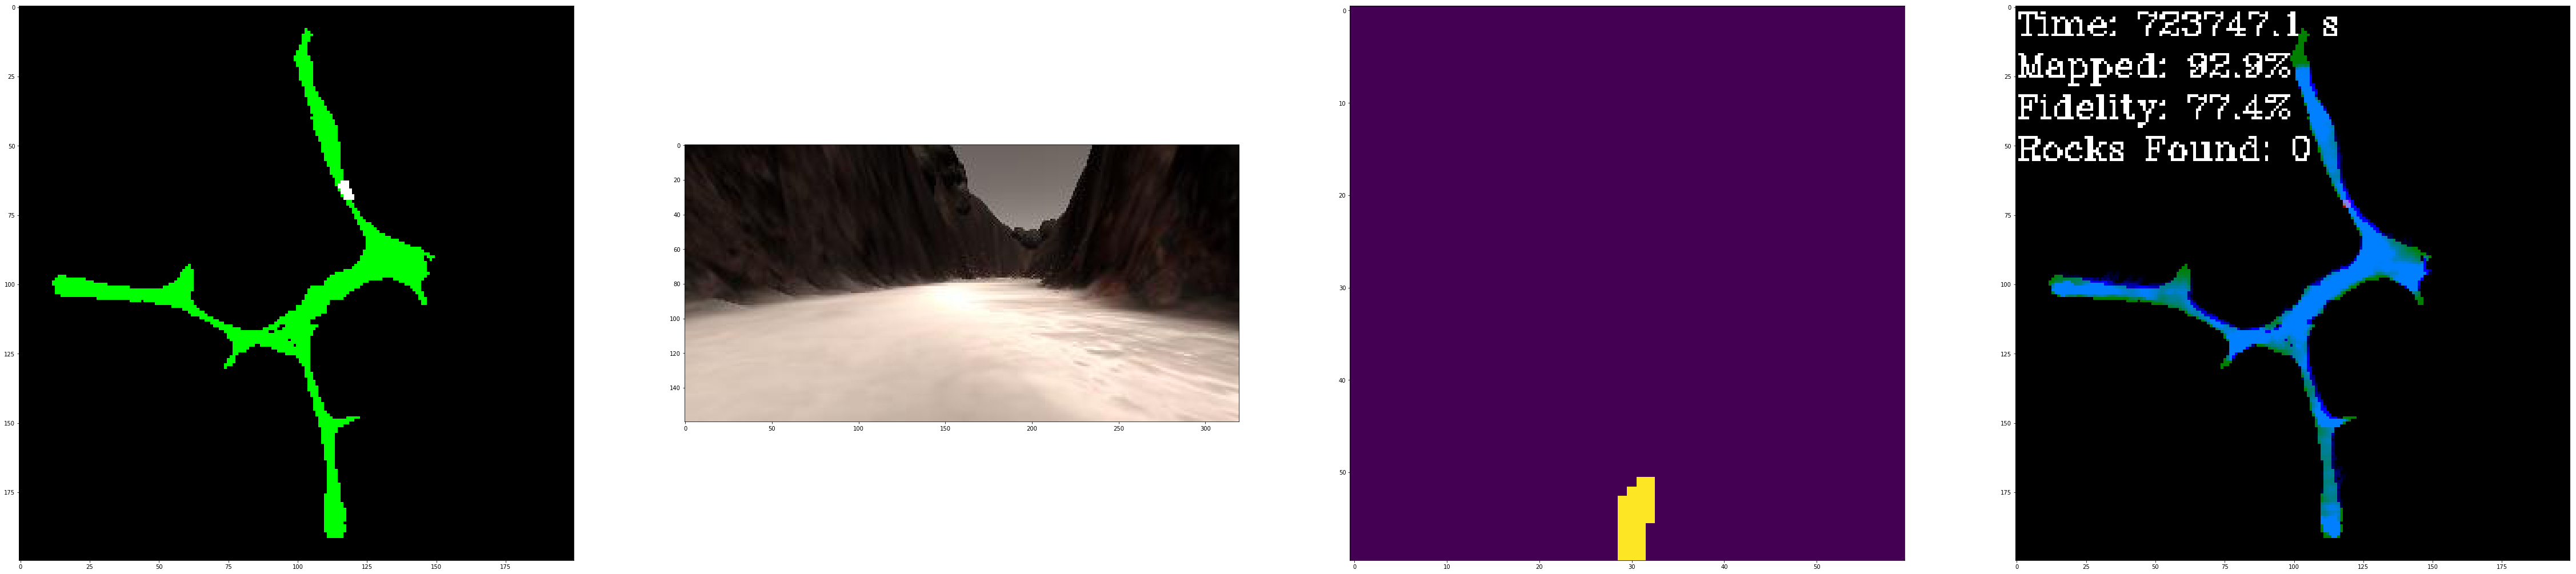

In [30]:
frame = pitch_cases[100]
#frame = frames[2100]
print('frame type info', frame.debug['type'])
#frame = frames[252]
#frame = high_fid_frames[0]
print('roll and pitch error:', circle_distance(frame.metric['Roll'], 0), 
      circle_distance(frame.metric['Pitch'], 0))
print ('yaw =', frame.metric['Yaw'], 'pitch = ', frame.metric['Pitch'], 'roll = ', frame.metric['Roll'])
print('frame position:', frame.metric['X_Position'], frame.metric['Y_Position'])
fig = plt.figure(figsize=(80,160)) # Create a figure for plotting
mp = highlight_position(frame.map, frame.metric['X_Position'], frame.metric['Y_Position'])

horizon_length = 320.0 / PIXEL_SCALING

pitch = (frame.metric['Pitch'] / 180) * np.pi
roll = -(frame.metric['Roll'] / 180) * np.pi
SINGULAR_ORI = int(perspect.get_singular(pitch) * PIXEL_SCALING)
SINGULAR = int(rot_perspect.get_singular(
    roll=roll, pitch=pitch, horizon_length=horizon_length) * PIXEL_SCALING)
print('SINGULAR = ', SINGULAR)
coords = convert_camera_coords(frame.frame)
particles = interpo.extract_particles(coords, singular=SINGULAR)

particles_ori = interpo.extract_particles(coords, singular=SINGULAR_ORI)
s_coords_ori = perspect.particle_transform(pitch, particles_ori)
s_coords = rot_perspect.particle_transform(
    pitch=pitch, roll=roll, particles=particles)

print('max x info:', particles[0, :].max(), s_coords[:, 0].max())
persp = render.render(s_coords)
persp_ori = render.render(s_coords_ori)

analysis = gradient_analyzer.analysis(
    frame.debug['map_gradients'], render=True)
print('map gradient: ratio =', analysis.ratio, 
      'pos =',analysis.pos, 'neg =', analysis.neg)
plt.subplot(141)
plt.imshow(analysis.render)
plt.subplot(142)
plt.imshow(frame.frame)
plt.subplot(143)
plt.imshow(persp)
plt.subplot(144)
plt.imshow(mp)
plt.show()

In [66]:
particles[0, :].max()

0.039984375000000003

In [68]:
s_coords = cperspect.particle_transform(particles)

In [69]:
s_coords[:, 0].max()

41.807765004679794

In [90]:
s_coords = pcperspect.particle_transform((frame.metric['Pitch'] / 180) * np.pi, particles)

[[ 0.22027432  0.        ]
 [-0.00774633  0.21374336]] [[-0.02074355]
 [-0.01685651]]


In [92]:
s_coords[:, 0].max()

7.2085968727585215

In [78]:
print(cperspect._w)

[[-0.21238859  0.        ]
 [-0.0077488  -0.22471291]]


In [135]:
interpo = StripwiseInterpolationOptimized(
    SINGULAR_PIXEL, PIXEL_SCALING, 
    lambda x: np.array(color_thresh(x, (160, 160, 160), 'float32').nonzero()))
pcperspect = PitchCalibratedPerspectiveInference(CAMERA_POSITION, VIEW_POINT_POSITION)
render = PerspectiveRender(scale=1, resolution=60)

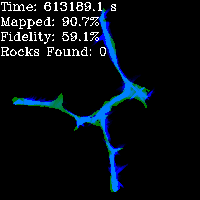

In [2]:
frames[-1].map

In [5]:
frames[0].debug

(('write_map', 1),)

In [3]:
len(frames)

2822

In [20]:
particles[:, 0]

array([ 0.,  0.])

In [7]:
roll, pitch

(0.023573848399758263, 6.2828172583169373)

In [17]:
VIEW_POINT_POSITION

array([ 0.04027264,  0.08037242, -0.05411853])

In [18]:
CAMERA_POSITION

array([ 0.27883144,  0.07262362,  0.17211595])

In [8]:
s_coords[0, :]

array([ 0.52422919,  0.43719429])

In [23]:
rolls.max()

1.3506820201873779

In [24]:
rolls.argmax()

117

In [28]:
frames[117].metrics['Roll']

IndexError: tuple index out of range

In [32]:
frames = []
for i in range(len(replay)):
    frame = replay.at(i)
    frames.append(frame)

In [34]:
rolls = np.array([circle_distance(x.metric['Roll'], 0) for x in frames])
pitches = np.array([circle_distance(x.metric['Pitch'], 0) for x in frames])

In [35]:
len(rolls)

499

In [20]:
np.where(rolls > 1)

(array([108, 109, 117, 118, 119, 171, 172, 173, 212, 213, 214, 215, 227,
        228, 229, 245, 246, 247, 251, 252, 253, 254, 255, 372, 373, 397,
        398, 399, 400, 401, 402, 403, 404, 405, 406, 469, 470, 471, 472,
        487, 488, 489]),)

In [6]:
frames

[]

In [7]:
len(replay)

5721

In [11]:
frame[-1]

array([[[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       [[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       [[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       ..., 
       [[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       [[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       [[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,

In [14]:
frames = []
for i in range(len(replay)):
    frame = replay.at(i)
    frames.append(frame)
        

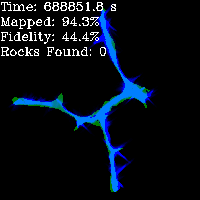

In [5]:
frames[-1].map

In [18]:
fidelities = np.array([x.fidelity for x in frames])

In [19]:
fidelities

array([ 38.6,  38.6,  38.6, ...,  29.1,  29.1,  29.1])

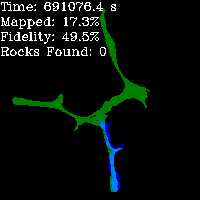

In [3]:
# positive roll zxy
frames[-1].map

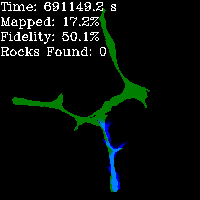

In [2]:
# negative roll zxy
frames[-1].map

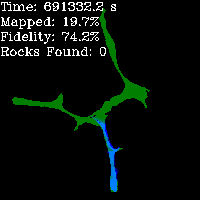

In [2]:
# negative roll zyx
frames[-1].map

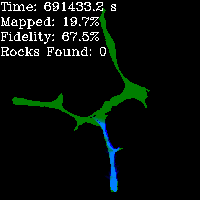

In [2]:
# positive roll zyx
frames[-1].map

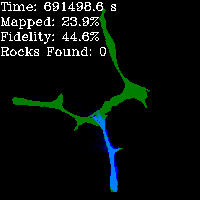

In [2]:
# negative roll zyx full
frames[-1].map

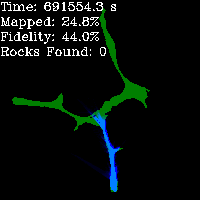

In [2]:
# positive roll zyx full
frames[-1].map

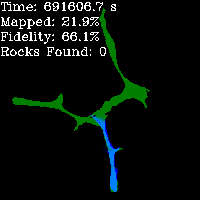

In [2]:
# negative roll zyx full - 1
frames[-1].map

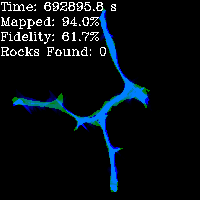

In [2]:
# negative roll combined
frames[-1].map

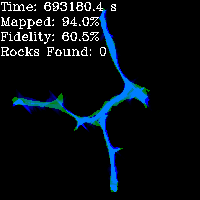

In [2]:
# positive roll combined
frames[-1].map

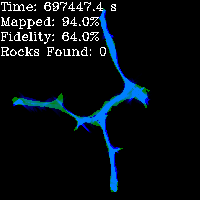

In [2]:
# positive roll combined -4
frames[-1].map

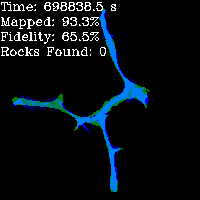

In [2]:
# positive roll combined -4
frames[-1].map

In [5]:
frames[3000].debug

(('type', 'zyx'),)

In [16]:
s_coords[:, 1].min()

-4.5083596441344485

In [38]:
mp = np.zeros((200, 200), dtype=np.uint8)

In [39]:
mp[[1,1, 2,3], [4,4, 5,6]] = 1

In [40]:
mp.nonzero()

(array([1, 2, 3]), array([4, 5, 6]))

In [101]:
rot = inverse_rotation_matrix(frame.metric['Yaw'])

In [102]:
rot

array([[ 0.74015474,  0.67243659],
       [-0.67243659, -0.74015474]])

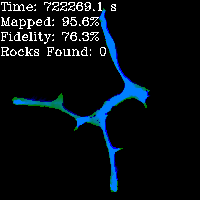

In [2]:
# negative roll
frames[-1].map

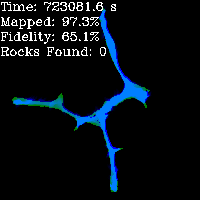

In [2]:
# positive roll
frames[-1].map

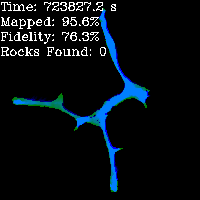

In [2]:
# positive roll
frames[-1].map

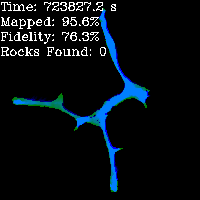

In [18]:
frames[-1].map

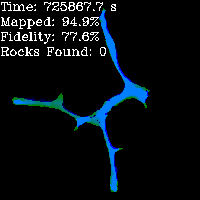

In [2]:
frames[-1].map

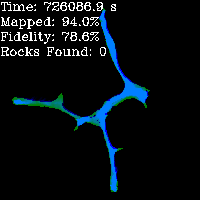

In [2]:
frames[-1].map

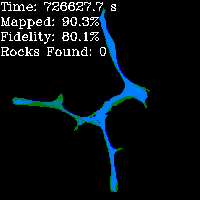

In [2]:
frames[-1].map

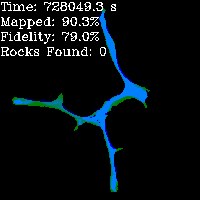

In [2]:
frames[-1].map

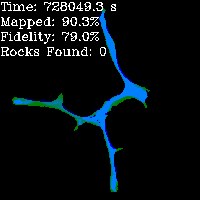

In [3]:
frames[-1].map